# playing Atari with Deep Learning
* ohne Frame Stack
* kein Replay Memory und Epsilon Greedy

(*) Bilder müssen auf kleineres Format reshaped werden als Original (210, 160, 3), da sonst zu Groß für GPU

## 1. Datensatz generieren per Zufallsspiel.
Es werden nur Sequenzen gespeichert, die einen Reward zurückgeben.

In [1]:
# choose game
game = "Pong-v0"

In [2]:
import gym
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

# zum erstellen des Spiels mit Wrappern
def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

In [3]:
import numpy as np

env = WarpFrameEnv(game)
x_data = [] # Bilder (States)
y_data = [] # Label (Aktionen)

DATASET_SIZE = 1000
saved_episodes = 0

# Datensatz generieren
the_end = False
while not the_end:
    done = False
    state = env.reset()
    episode_obs = []
    episode_acts = []
  
    while not done:
        action = env.action_space.sample()
        episode_obs.append(state)
        episode_acts.append(action)
        state, reward, done, info = env.step(action)
    
        if reward < 0:
            episode_acts = []
            episode_obs = []
        elif reward > 0:
            x_data += episode_obs
            y_data += episode_acts
            episode_obs = []
            episode_acts = []
            saved_episodes += 1
            if saved_episodes % 100 == 0:
                print(saved_episodes)
            if saved_episodes+1 > DATASET_SIZE:
                print("Dataset completed")
                the_end = True

100
200
300
400
500
600
700
800
900
1000
Dataset completed
Dataset completed


In [7]:
len(x_data), len(y_data)

(79840, 79840)

In [8]:
# Zählen wie häufig jede Aktion getätigt wurde
from collections import Counter
counted_actions = Counter(y_data)

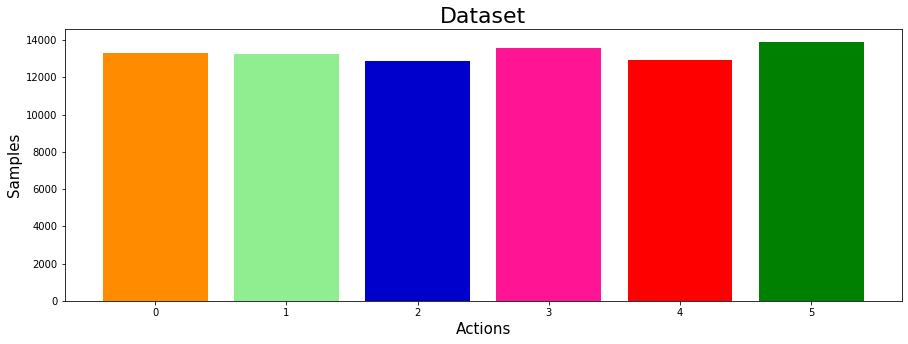

In [9]:
import matplotlib.pyplot as plt
colors = ['red', 'darkorange', 'green', 'mediumblue', 'lightgreen', 'deeppink']
plt.figure(figsize=(15, 5))
plt.bar(counted_actions.keys(), counted_actions.values(), color=colors)
plt.title("Dataset", fontsize=22)
plt.xlabel("Actions", fontsize=15)
plt.ylabel("Samples", fontsize=15)
plt.show()

In [10]:
# normalisieren des Datensatzes
MAX = np.max(x_data)
x_data = x_data / MAX

np.min(x_data), np.max(x_data)

(0.22033898305084745, 1.0)

In [11]:
# Teilen in Training und Test, shuffeln des Datensatzes
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size=0.2)

In [12]:
len(y_train), len(y_test)

(63872, 15968)

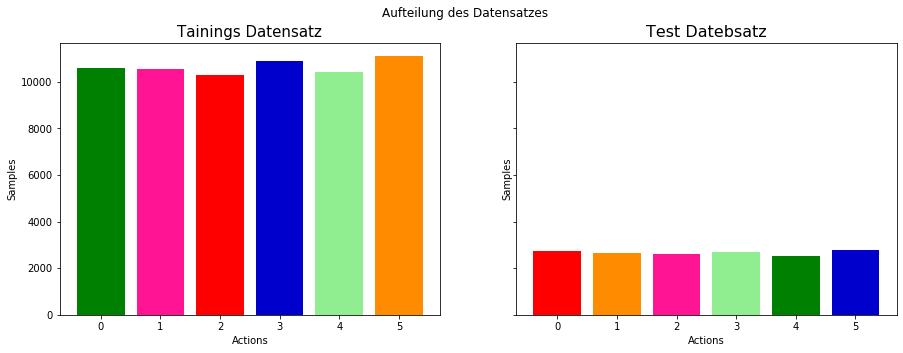

In [18]:
count_train = Counter(y_train)
count_test = Counter(y_test)

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle("Aufteilung des Datensatzes", fontsize=22)
axs[0].bar(count_train.keys(), count_train.values(), color=colors)
axs[0].set_title("Tainings Datensatz", fontsize=15)
axs[0].set_xlabel("Actions")
axs[0].set_ylabel("Samples")

axs[1].bar(count_test.keys(), count_test.values(), color=colors)
axs[1].set_title("Test Datebsatz", fontsize=16)
axs[1].set_xlabel("Actions")
axs[1].set_ylabel("Samples")
plt.show()

In [19]:
# konvertieren in richtiges Format
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

## 2. Erstellen des künstlichen neuronalen Netzes

In [20]:
# Input und Output shape
INPUT_SHAPE = np.shape(x_data)[1:]
OUTPUT_SHAPE = 1

In [22]:
import tensorflow
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

net_input = Input(shape=INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
x = Activation("relu")(x)
x = Flatten()(x)
x = Dense(512)(x)
x = Activation("relu")(x)
net_output = Dense(OUTPUT_SHAPE)(x)

LOSS_FUNCTION = Huber()
OPTIMIZER = Adam(lr=0.0005)

model = Model(inputs=net_input, outputs=net_output)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

In [23]:
EPOCHS = 30

training = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=EPOCHS, 
    verbose=1)

Epoch 1/30


W1229 16:15:45.354696 139854935250752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1393: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1229 16:15:45.449472 139854935250752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


63872/63872 [==============================] - 17s 271us/sample - loss: 1.0660
Epoch 2/30
63872/63872 [==============================] - 15s 233us/sample - loss: 1.0555
Epoch 3/30
63872/63872 [==============================] - 14s 213us/sample - loss: 1.0534
Epoch 4/30
63872/63872 [==============================] - 14s 220us/sample - loss: 1.0532
Epoch 5/30
63872/63872 [==============================] - 15s 235us/sample - loss: 1.0524
Epoch 6/30
63872/63872 [==============================] - 14s 224us/sample - loss: 1.0520
Epoch 7/30
63872/63872 [==============================] - 14s 220us/sample - loss: 1.0514
Epoch 8/30
63872/63872 [==============================] - 14s 222us/sample - loss: 1.0511
Epoch 9/30
63872/63872 [==============================] - 14s 219us/sample - loss: 1.0516
Epoch 10/30
63872/63872 [==============================] - 15s 228us/sample - loss: 1.0516
Epoch 11/30
63872/63872 [==============================] - 14s 216us/sample - loss: 1.0511
Epoch 12/30
63872/6

In [24]:
model.evaluate(x_test, y_test, verbose=0)

1.055940805551762

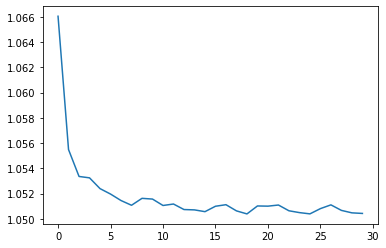

In [25]:
import matplotlib.pyplot as plt
model_hist = training.history
plt.plot(model_hist['loss'])
plt.show()

In [27]:
y_pred = model.predict(x_test)
y_pred

array([[2.5298357],
       [2.5298357],
       [2.5298357],
       ...,
       [2.5298357],
       [2.5298357],
       [2.5298357]], dtype=float32)

## 3. Spielen mit trainiertem neuronalen Netz

In [ ]:
EPISODES = 5

for episode in range(EPISODES):
    state = env.reset()
    state = state.reshape(1, 84, 84, 1)
    state = state.astype(np.float32)
    done = False
    Episode_Reward = 0
    while not done:
        action = model.predict(state)[0][0]
        action = int(round(action, 0))
        state, reward, done, info = env.step(action)
        state = state.reshape(1, 84, 84, 1)
        state = state.astype(np.float32)
        Episode_Reward += reward
        
        if done:
            print("Episode:", episode, "\tReward:", Episode_Reward)

Episode: 0 	Reward: -21.0
Episode: 1 	Reward: -21.0
Episode: 2 	Reward: -21.0
